# HDF5 + Python

Let's say you have a giant array that you need to work with. So giant, in fact, that it is bigger than your computer's temporary memory. What can we do? 

## HDF5 Background

HDF5 (Hierarchical Data Format) is a file format that can handle your data, no matter how big your data are. There are packages for working with HDF5 files in most languages. HDF5 [has been suggested](https://arxiv.org/abs/1411.0507) as a possible replacement for FITS files in the astronomy community, but there's enough inertia that it's probable that this is the first time you'll hear about HDF5.

The Python package for working with HDF5 files is `h5py` ([docs](http://docs.h5py.org/en/latest/index.html)).

## First example

Let's say you have a 3D numpy array that you want to store. Let's make an array with shape `(10, 10, 10)` to start:

In [10]:
import numpy as np
np.random.seed(2016)

data = np.random.randn(1000).reshape((10, 10, 10))

You could save this in a FITS file, you could save this as a numpy pickle file. We're going to save it with HDF5. Starting a new file with HDF5 is a little cumbersome, but let's go for it: 

In [11]:
import h5py   # This is the python interface to HDF5

f = h5py.File('data.hdf5', 'w')  # 'w' indicates we are creating this file

An HDF5 file contains _datasets_. A dataset is an array with one data type. Let's create one for `data`.

In [12]:
dataset = f.create_dataset('dataset', shape=data.shape, dtype=data.dtype)
dataset

<HDF5 dataset "dataset": shape (10, 10, 10), type "<f8">

To fill a dataset with data, you need to take a slice of the dataset:

In [13]:
dataset[:] = data

Now `dataset` can be sliced like a numpy array (with some caveats), and the arrays returned will be numpy arrays. The trick going on behind the scenes is that `h5py` will only access the memory for the parts of the data cube that you slice for. This is powerful because your data cube could contain 10 GB of information on a machine with 2 GB of RAM, but if you try to access only `dataset[0, 0, :]`, you'll only read that slice of the data cube from memory.

Let's do a quick computation on a slice of the dataset: 

In [14]:
image = dataset[0, :, :]

image.mean()

-0.047977742397473877

Note: for datasets with high dimensions, you can use the ellipsis (`...`) syntax for specifying "give me all of the values from all of the remaining dimensions", like this:

In [15]:
# This: 
image = dataset[0, :, :]

# is equivalent to this: 
image = dataset[0, ...]

When we're done with a file, we should close the file stream: 

In [16]:
f.close()

# Big(ger) Data Example

The above example used a small dataset to demonstrate the functionality of `h5py` without taking up all of your memory. If you have plenty of disk space (0.6 GB), you may procede with caution to the example below. 

**Warning**: you should only do the example below if you have sufficient disk space to store a 0.6 GB file.

We will create a really big dataset, and use one of the [HDF5 compression types](http://docs.h5py.org/en/latest/high/dataset.html#lossless-compression-filters) to store it on your machine succinctly. 

In [17]:
sufficient_disk_space = False

if sufficient_disk_space:
    f = h5py.File('big_data.hdf5', 'w')
    
    # Set image dimensions, number of images
    image_dimensions = (2048, 2048)
    number_images = 20
    
    # Create a dataset, and specify that it will be compressed with the LZF algorithm 
    images = f.create_dataset('images', dtype=np.float64, compression='lzf',
                              shape=(number_images, image_dimensions[0], image_dimensions[1]))
    
    # Create random images, and add them to the HDF5 archive
    for i in range(number_images):
        n_pixels = image_dimensions[0] * image_dimensions[1]
        random_image = np.random.randn(n_pixels).reshape(image_dimensions)
        
        images[i, ...] = random_image
        
    # Close the file stream
    f.close()

If we do the math, this is how large we'd expect that file to be without compression:

In [18]:
if sufficient_disk_space:
    print(number_images * image_dimensions[0] * image_dimensions[1] * 64 / 1e9, "GB")

5.36870912 GB


But the actual size of the file is: 

In [19]:
%%bash
ls -lh big_data.hdf5

-rw-r--r--  1 bmmorris  staff   615M Aug 27 16:11 big_data.hdf5


The `LZF` compression algorithm is very fast, but not the most compact (try `gzip` for an alternative which is slower but compresses the file a bit more).

Now let's access the data in that HDF5 archive: 

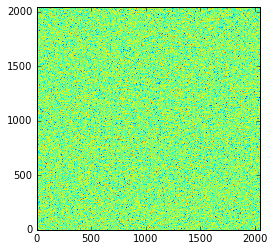

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt

if sufficient_disk_space:
    f = h5py.File('big_data.hdf5', 'r')

    # access the images dataset
    images = f['images']
    
    # Get the first image from the dataset:
    first_image = images[0, ...]
    
    plt.imshow(first_image, origin='lower', interpolation='nearest')
    plt.show()

Now notice - we didn't have to wait for the whole file to load into memory, and we didn't have to specify the compression to decompress it - we just asked for the slice of data that we wanted, and we got it! That's because the `images` variable is not holding the whole numpy array, it's holding the `h5py` HDF5 dataset object, which behaves like a numpy array without actually being one.

In [38]:
if sufficient_disk_space:
    print(images)
    f.close()

<HDF5 dataset "images": shape (20, 2048, 2048), type "<f8">


### Exercise: 

Open your operating system's activity monitor, and look at how much memory is being used currently. 

Now in the cell below: 
1. Open the HDF5 archive `big_data` that we created earlier. 
2. Write a loop that measures the standard deviation of the values in each image
3. Check that the whole data cube isn't being accessed using your system's activity monitor